In [ ]:
%pip install keras-tuner --upgrade

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import subprocess

In [ ]:
subprocess.run(['java', '-jar', 'createDataset.jar', '-ss', 'RandomConfiguration', '-m', '100', '-fm', './bcs_v1.xml', '-c', './products.csv'], capture_output=True)

In [ ]:
# get dataset
dataset = pd.read_csv("Data/Apache_AllNumeric.csv")
dataset = dataset.sample(frac=1)
dataset_features = dataset.copy()
dataset_labels = dataset_features.pop('PERF')

In [ ]:
dataset

In [ ]:
# normalize dataset (MinMaxScale)
features_max = dataset_features.max()
labels_max = dataset_labels.max()
dataset_features /= features_max
dataset_labels /= dataset_labels.max()

In [ ]:
dataset_labels

In [ ]:
# split dataset train (2/3) test (1/3)
x, x_test, y, y_test = train_test_split(dataset_features, dataset_labels, test_size=0.33)

In [ ]:
x

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    for i in range(hp.Int("num_layers", 1, 11)):
        model.add(
            keras.layers.Dense(
                units=hp.Int(f"units_{i}", min_value=8, max_value=256, step=8),
                activation=hp.Choice("activation", ["relu", "tanh", "sigmoid"])
            )
        )
    if hp.Boolean("dropout"):
        model.add(keras.layers.Dropout(rate=hp.Choice("dr", [0.25, 0.5])))
    model.add(keras.layers.Dense(1))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-1, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mean_squared_error",
        metrics=[keras.metrics.MeanSquaredError()]
    )
    return model

In [ ]:
tuner = kt.BayesianOptimization(
    hypermodel = build_model,
    objective="mean_squared_error",
    max_trials=10,
    overwrite=True,
    directory="my_tuner",
    project_name="feature_degradation",
)

In [ ]:
es = keras.callbacks.EarlyStopping(
    monitor="mean_squared_error",
    patience=5,
    restore_best_weights=True
)

In [ ]:
tuner.search_space_summary()

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

In [ ]:
x_train

In [ ]:
tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val), callbacks=[es])

In [ ]:
tuner.results_summary()

In [ ]:
best_hps = tuner.get_best_hyperparameters(5)
model = build_model(best_hps[0])
history = model.fit(x_train, y_train, batch_size=20, epochs=20, validation_data=(x_val, y_val),)

In [ ]:
def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.savefig("mse_per_epoch.png")

print("Defined the plot_the_loss_curve function.")

In [ ]:
epochs = history.epoch
hist = pd.DataFrame(history.history)
mse = hist["mean_squared_error"]

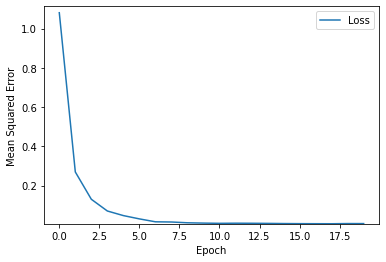

In [32]:
plot_the_loss_curve(epochs, mse)

In [ ]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

In [ ]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=5)

In [55]:
print("Generate predictions for 3 samples\n")
test = x_test[:3]
print(test)
predictions = model.predict(test)
print("predictions:\n", predictions*labels_max)
print("real values \n", np.array([dataset['PERF'][test.index]]).swapaxes)

Generate predictions for 3 samples

     HostnameLookups  KeepAlive  EnableSendfile  FollowSymLinks  AccessLog  \
182              1.0        1.0             0.0             0.0        1.0   
183              1.0        0.0             0.0             1.0        1.0   
160              0.0        0.0             0.0             0.0        1.0   

     ExtendedStatus  InMemory  Handle  
182             0.0       1.0     0.0  
183             0.0       1.0     0.0  
160             1.0       1.0     0.0  
predictions:
 [[1829.4746]
 [1036.1244]
 [1361.4297]]
real values 
 <built-in method transpose of numpy.ndarray object at 0x7f08f2ca49f0>


In [51]:
dataset['PERF'][test.index]

182    1980
183    1020
160    1140
Name: PERF, dtype: int64

In [ ]:
np.concatenate((test, predictions*labels_max), axis=1)


In [ ]:
print(predictions*labels_max)